In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import itertools
#import other python scripts for further anlaysis
import reshape
import plotFW
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/'
# Subjects and tasks
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
#DS combination
DSvars=list(itertools.product(list(subsComb),list(taskList)))
##SS combination
SSvars=list(itertools.product(list(subList),list(tasksComb)))
#BS combination
BSvars=list(itertools.product(list(subsComb),list(tasksComb)))


""" run_prediction initializes what type of analysis you would like to do
and what classifier you would like to use. For now classifier options are svm:linear svm, logreg: logistic
regression, and ridge:ridge regression. Analysis is the type of analysis you wanted
to run. DS--different subject same task; SS--same subject different task;
BS--different subject different task. Each analysis will concatenate across
subjects and make a dataframe. If FW is true will collect all necessary feature weights and plot or save then
into the appropriate format. If plotACC=True will plot the accuracy as heatmaps.
If statsACC=True will make tables of the mean and sd for each task."""
def run_prediction(classifier, analysis, FW=False, stats=False):
    if analysis=='CV':
        classifyCV(classifier, analysis, FW, stats)
    elif analysis=='DS':
        classifyDS(classifier, analysis, FW, stats)
    elif analysis=='SS':
        classifySS(classifier, analysis, FW, stats)
    elif analysis=='BS':
        classifyBS(classifier, analysis, FW, stats)
    else:
        print('did not specify analysis')
def classifyDS(classifier, analysis, FW, stats):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(DSvars, columns=['sub','task'])
    dfDS=pd.DataFrame()
    dfDS[['train_sub','test_sub']]=pd.DataFrame(tmp_df['sub'].tolist())
    dfDS['task']=tmp_df['task']
    for index, row in dfDS.iterrows():
        score=model(classifier, analysis,FW, train_sub=row['train_sub'], test_sub=row['test_sub'], train_task=row['task'], test_task=row['task'])
        acc_scores_per_task.append(score)
    dfDS['acc']=acc_scores_per_task
    if stats is True:
        plotACC(dfDS, classifier, analysis)
        statsACC(dfDS, classifier, analysis)
        boxACC(dfDS, classifier, analysis)
    else:
        print('skipping stats')
    dfDS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)
def classifySS(classifier,analysis, FW, stats):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(SSvars, columns=['sub','task'])
    dfSS=pd.DataFrame()
    dfSS[['train_task','test_task']]=pd.DataFrame(tmp_df['task'].tolist())
    dfSS['sub']=tmp_df['sub']
    for index, row in dfSS.iterrows():
        score=model(classifier, analysis,FW, train_sub=row['sub'], test_sub=row['sub'], train_task=row['train_task'], test_task=row['test_task'])
        acc_scores_per_task.append(score)
    dfSS['acc']=acc_scores_per_task
    if stats is True:
        plotACC(dfSS, classifier, analysis)
        statsACC(dfSS, classifier, analysis)
        boxACC(dfSS, classifier, analysis)
    else:
        print('skipping stats')
    #save accuracy
    dfSS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)
def classifyBS(classifier, analysis, FW, stats):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(BSvars, columns=['sub','task'])
    dfBS=pd.DataFrame()
    dfBS[['train_task','test_task']]=pd.DataFrame(tmp_df['task'].tolist())
    dfBS[['train_sub', 'test_sub']]=pd.DataFrame(tmp_df['sub'].tolist())
    for index, row in dfBS.iterrows():
        score=model(classifier, analysis,FW, train_sub=row['train_sub'], test_sub=row['test_sub'], train_task=row['train_task'], test_task=row['test_task'])
        acc_scores_per_task.append(score)
    dfBS['acc']=acc_scores_per_task
    if stats is True:
        plotACC(dfBS, classifier, analysis)
        statsACC(dfBS, classifier, analysis)
        boxACC(dfBS, classifier, analysis)
    else:
        print('skipping stats')
    #save accuracy
    dfBS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)
def model(classifier, analysis,FW, train_sub, test_sub, train_task, test_task):
    taskFC=reshape.matFiles(dataDir+train_task+'/'+train_sub+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
    x_train, y_train=reshape.concateFC(taskFC, restFC)
    #if your subs are the same dont include rest...avoid overfitting!!
    if train_sub==test_sub:
        x_test=reshape.matFiles(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        taskSize=x_test.shape[0]
        y_test=np.ones(taskSize, dtype=int)
    else:
        test_taskFC=reshape.matFiles(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        test_restFC=reshape.matFiles(dataDir+'rest/'+test_sub+'_parcel_corrmat.mat')
        x_test, y_test=reshape.concateFC(test_taskFC, test_restFC)
    folds=taskFC.shape[0]  
    if classifier=='SVC':
        svc=LinearSVC()
        param_grid={'C':[1]}
        clf=GridSearchCV(svc, param_grid)
    elif classifier=='logReg':
        clf=LogisticRegressionCV(cv=folds)
    elif classifier=='ridge':
        clf=RidgeClassifierCV(cv=folds)
    else:
        print('Error: You didnt specify what classifier')
    clf.fit(x_train,y_train)

    CVscores=cross_val_score(clf,x_train,y_train, cv=folds)
    if FW is True:
        coef=clf.coef_
        plotFW.feature_plots(coef, classifier, analysis, train_task, train_sub)
    else:
        print('skipping feature weights')
    
    predict=clf.predict(x_test)
    #Get accuracy of model
    ACCscores=clf.score(x_test,y_test)
    return ACCscores
#Calculate acc of cross validation within sub within task
def classifyCV(classifier, analysis, FW, stats):
    avg_CV=[]
    if classifier=='SVC':
        clf=LinearSVC()
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs')
    elif classifier=='ridge':
        clf=RidgeClassifier()
    else:
        print('invalid classifier')
    for task in taskList:
        acc_scores_per_task=[]
        cvTable=[]
        for sub in subList:
            taskFC=reshape.matFiles(dataDir+task+'/'+sub+'_parcel_corrmat.mat')
            restFC=reshape.matFiles(dataDir+'rest/'+sub+'_parcel_corrmat.mat')
            folds=taskFC.shape[0]
            x_train, y_train=reshape.concateFC(taskFC, restFC)
            CVscores=cross_val_score(clf, x_train, y_train, cv=folds)
            mu=CVscores.mean()
            acc_scores_per_task.append(mu)
            cv_tmp_df=pd.DataFrame({sub:CVscores})
            cvTable.append(cv_tmp_df)
    #acc per fold per sub
        tmp_df=pd.DataFrame({'sub':subList, task:acc_scores_per_task}).set_index('sub')
        avg_CV.append(tmp_df)
        cvTable=pd.concat(cvTable, axis=1)
    #saving cv per folds if debugging
        cvTable.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/cvTable_folds.csv', index=False)
    #average acc per sub per tasks
    df=pd.concat(avg_CV, axis=1)
    if stats is True:
        boxACC(df, classifier, analysis)
        plotACC(df, classifier, analysis)
        statsACC(df, classifier, analysis)
    else:
        print('skipping stats')
    df.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
#import other python scripts for further anlaysis
import reshape
import plotFW
import results
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/'
#Subjects and tasks
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']

def boxACC(df, classifier, analysis):
    if analysis=='CV':
        print('cross validation boxplots')
        df=pd.melt(df, value_vars=['mixed','motor','mem'], var_name='task', value_name='acc')
        #df.drop('sub', axis=1, inplace=True)
        plt.figure(figsize=(15,8))
        ax=sns.boxplot(x='task', y='acc', data=df)
        ax.set_title('Cross Validation')
        ax.set_xlabel('Test Task')
        ax.set_ylabel('Accuracy')
        #fig=ax.get_figure()
        plt.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/boxplot.png', bbox_inches='tight')
    elif analysis=='SS':
        print('same sub boxplots')
        #df.drop(['sub'], axis=1, inplace=True)
        plt.figure(figsize=(15,8))
        ax=sns.boxplot(x='test_task', y='acc', hue='train_task', data=df)
        ax.axhline(.50, ls='--', color='r')
        ax.set_title(classifier)
        ax.set_xlabel('Test Task')
        ax.set_ylabel('Accuracy')
        ax.legend(title='Train Task',loc='upper right')
        fig=ax.get_figure()
        fig.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/boxplot.png', bbox_inches='tight')
    elif analysis=='DS':
        #df.drop(['train_sub', 'test_sub'], axis=1, inplace=True)
        plt.figure(figsize=(15,8))
        ax=sns.boxplot(x='task', y='acc', data=df)
        ax.axhline(.50, ls='--', color='r')
        ax.set_title('Different Sub Same Task')
        ax.set_xlabel('Test Task')
        ax.set_ylabel('Accuracy')
        fig=ax.get_figure()
        fig.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/boxplot.png', bbox_inches='tight')
    elif analysis=='BS':
        print('diff sub diff task boxplots')
        #df.drop(['train_sub', 'test_sub'], axis=1, inplace=True)
        plt.figure(figsize=(15,8))
        ax=sns.boxplot(x='test_task', y='acc', hue='train_task', data=df)
        ax.axhline(.50, ls='--', color='r')
        ax.set(ylim=(.4))
        ax.set_title('Between Sub Between Task')
        ax.set_xlabel('Test Task')
        ax.set_ylabel('Accuracy')
        ax.legend(title='Train Task',loc='upper right')
        fig.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/boxplot.png', bbox_inches='tight')
    else:
        print('skipping boxplots')

def plotACC(df, classifier, analysis):
    if analysis == 'CV':
        plt.figure()
        print('task by subject heatmap')
        heat=sns.heatmap(df, annot=True, vmin=.5, vmax=1)
        #fig=heat.get_figure()
        plt.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/heatmap.png', bbox_inches='tight')
    elif analysis=='SS':
        print('task by subject heatmap')
        grouped_df=df.groupby('test_task')
        for task in taskList:
            task_df=grouped_df.get_group(task)
            task_df.drop(columns=['test_task'], inplace=True)
            task_df=task_df.pivot(index='sub', columns='train_task', values='acc')
            plt.figure()
            ax=sns.heatmap(task_df, annot=True, vmin=.5, vmax=1)
            ax.set_title('Testing ' + task)
            ax.set_xlabel('Training Variables')
            fig=ax.get_figure()
            fig.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/'+task+'_heatmap.png', bbox_inches='tight')
    elif analysis =='DS':
        print('subject by subject heatmap')
        grouped_df=df.groupby('task')
        for task in taskList:
            task_df=grouped_df.get_group(task)
            task_df.drop(columns=['task'], inplace=True)
            task_df=task_df.pivot(index='test_sub', columns='train_sub', values='acc')
            plt.figure()
            ax=sns.heatmap(task_df, annot=True, vmin=.5, vmax=1)
            ax.set_title('Testing ' + task)
            ax.set_xlabel('Training Variables')
            ax.set_ylabel('Testing Variables')
            fig=ax.get_figure()
            fig.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/'+task+'_heatmap.png', bbox_inches='tight')
    elif analysis =='BS':
        print('subject by subject per train task split heatmap')
        test_group=df.groupby('test_task')
        for test_task in taskList:
            task_df=test_group.get_group(test_task)
            for train_task in taskList:
                if test_task==train_task:
                    continue
                else:
                    df=task_df[task_df['train_task']==train_task]
                    df.drop(columns=['train_task'], inplace=True)
                    df.drop(columns=['test_task'], inplace=True)
                    df=df.pivot(index='test_sub', columns='train_sub', values='acc')
                    plt.figure()
                    ax=sns.heatmap(df, annot=True, vmin=.5, vmax=1)
                    ax.set_title('Testing ' + test_task+' Training '+train_task)
                    ax.set_xlabel('Training Variables')
                    ax.set_ylabel('Testing Variables')
                    fig=ax.get_figure()
                    fig.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/train_'+train_task+'_test_'+test_task+'_heatmap.png', bbox_inches='tight')
    else:
        print('skipping heatmaps')
def statsACC(df, classifier, analysis):
    if analysis=='CV':
        print('cross validation stats')
        mu=df.mean()
        sd=df.std()
        stats=pd.DataFrame({'Mean':mu, 'Std':sd})
        stats.to_csv(outDir+ 'results/' +classifier+'/acc/'+analysis+'/stats.csv', index=True)
    elif analysis=='SS':
        print('same sub stats')
        df.drop(['sub'], axis=1, inplace=True)
        stats=df.groupby(['test_task', 'train_task']).mean()
        stats.rename(columns={'acc':'Mean'}, inplace=True)
        sd=df.groupby(['test_task', 'train_task']).std()
        stats['Std']=sd['acc']
        stats.reset_index(inplace=True)
        stats.to_csv(outDir+ 'results/' +classifier+'/acc/'+analysis+'/stats.csv', index=True)
    elif analysis=='DS':
        print('diff sub stats')
        df.drop(['train_sub', 'test_sub'], axis=1, inplace=True)
        stats=df.groupby('task').mean()
        stats.rename(columns={'acc':'Mean'}, inplace=True)
        sd=df.groupby('task').std()
        stats['Std']=sd['acc']
        stats.to_csv(outDir+ 'results/' +classifier+'/acc/'+analysis+'/stats.csv', index=True)
    elif analysis=='BS':
        print('diff sub diff task stats')
        df.drop(['train_sub', 'test_sub'], axis=1, inplace=True)
        stats=df.groupby(['test_task', 'train_task']).mean()
        stats.rename(columns={'acc':'Mean'}, inplace=True)
        sd=df.groupby(['test_task', 'train_task']).std()
        stats['Std']=sd['acc']
        stats.reset_index(inplace=True)
        stats.to_csv(outDir+ 'results/' +classifier+'/acc/'+analysis+'/stats.csv', index=True)
    else:
        print('skipping stats')


In [ ]:
import classify
classify.run_prediction('ridge', 'CV', FW=False, stats=True)

In [ ]:
import pandas as pd
SVC=pd.read_csv('/Users/Alexis/Desktop/MSC_Alexis/analysis/output/mL/results/SVC/acc/CV/acc.csv')
log=pd.read_csv('/Users/Alexis/Desktop/MSC_Alexis/analysis/output/mL/results/logReg/acc/CV/acc.csv')
ridge=pd.read_csv('/Users/Alexis/Desktop/MSC_Alexis/analysis/output/mL/results/Ridge/acc/CV/acc.csv')

SVC.drop(columns='sub', inplace=True)
SVC_un=SVC.melt(value_vars=['mixed', 'motor','mem'], var_name='Task', value_name='Accuracy')
SVC_un['Analysis']='SVC'

log.drop(columns='sub', inplace=True)
log_un=log.melt(value_vars=['mixed', 'motor','mem'],var_name='Task', value_name='Accuracy')
log_un['Analysis']='logReg'

ridge.drop(columns='sub', inplace=True)
ridge_un=ridge.melt(value_vars=['mixed', 'motor','mem'],var_name='Task', value_name='Accuracy')
ridge_un['Analysis']='Ridge'

In [ ]:
import os
import sys
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/'

In [ ]:
classifiers=[SVC_un, log_un, ridge_un]
result = pd.concat(classifiers)


In [ ]:
ticks=[.9, .92, .94, .96, .98, 1]
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")
plt.figure(figsize=(15,8))
ax=sns.barplot('Analysis', 'Accuracy', hue='Task', data=result)
ax.set(ylim=(.9, 1.03))
ax.set_yticklabels(ticks)
ax.set_title('Cross Validation Across Models')
ax.legend(loc='upper right')
plt.savefig(outDir +'presentation/cv_barplot.png', bbox_inches='tight')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df=pd.read_csv('/Users/aporter1350/Desktop/MSC_Alexis/analysis/output/mL/results/SVC/acc/SS/acc.csv')
#df.drop(['sub'], axis=1, inplace=True)
plt.figure(figsize=(8,6))
sns.set_context("talk")
ax=sns.boxplot(x='test_task', y='acc', hue='train_task', data=df)
ax.axhline(.50, ls='--', color='r')
ax.set_title('SVC')
ax.set_xlabel('Test Task')
ax.set_ylabel('Accuracy')
ax.legend(title='Train Task',loc='lower left')
fig=ax.get_figure()
#fig.savefig(outDir +'images/'+classifier+'/acc/'+analysis+'/boxplot.png', bbox_inches='tight')


In [ ]:
#DS
import pandas as pd
import os
import sys
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/'


SVC=pd.read_csv(outDir+'results/SVC/acc/DS/acc.csv')
SVC['Analysis']='SVC'
log=pd.read_csv(outDir+'results/logReg/acc/DS/acc.csv')
log['Analysis']='logReg'
ridge=pd.read_csv(outDir+'results/Ridge/acc/DS/acc.csv')
ridge['Analysis']='Ridge'
classifiers=[SVC, log, ridge]
result = pd.concat(classifiers)

ticks=[.5, .6, .7, .8, .9, 1]
sns.set_context("talk")
plt.figure(figsize=(15,8))
ax=sns.boxplot('Analysis', 'acc', hue='task', data=result)
ax.set(ylim=(.3, 1.03))
ax.axhline(.50, ls='--', color='r')
ax.set_ylabel('Accuracy')
ax.set_title('Different Subject Same Task Across Models')
ax.legend(title='Task',loc='lower left')
plt.savefig(outDir +'presentation/ds_boxplot.png', bbox_inches='tight')

In [ ]:
SVC=pd.read_csv(outDir+'results/SVC/acc/SS/acc.csv')
SVC['Analysis']='SVC'
log=pd.read_csv(outDir+'results/logReg/acc/SS/acc.csv')
log['Analysis']='logReg'
ridge=pd.read_csv(outDir+'results/Ridge/acc/SS/acc.csv')
ridge['Analysis']='Ridge'
classifiers=[SVC, log, ridge]
result = pd.concat(classifiers)
result['Train.Test']=result['train_task']+'.'+result['test_task']
sns.set_context("talk")
plt.figure(figsize=(28,8))
colors = ["#0000CC", "#69A7EF","#FD8A07","#FCCF8C","#21B056","#84E5A8"]
# Set color palette
sns.set_palette(sns.color_palette(colors))
ax=sns.boxplot(x="Analysis", y="acc", hue='Train.Test', data=result)
ax.axhline(.50, ls='--', color='r')
ax.set_ylabel('Accuracy', fontsize=25)
ax.set_xlabel('Analysis', fontsize=25)
ax.set_title('Same Subject Between Task Across Models', fontsize=30)
ax.legend(loc='lower left')
plt.savefig(outDir +'presentation/ss_boxplot.png', bbox_inches='tight')

In [ ]:
SVC=pd.read_csv(outDir+'results/SVC/acc/BS/acc.csv')
SVC['Analysis']='SVC'
log=pd.read_csv(outDir+'results/logReg/acc/BS/acc.csv')
log['Analysis']='logReg'
ridge=pd.read_csv(outDir+'results/Ridge/acc/BS/acc.csv')
ridge['Analysis']='Ridge'
classifiers=[SVC, log, ridge]
result = pd.concat(classifiers)
result['Train.Test']=result['train_task']+'.'+result['test_task']
sns.set_context("talk")
plt.figure(figsize=(28,14))
colors = ["#0000CC", "#69A7EF","#FD8A07","#FCCF8C","#21B056","#84E5A8"]
# Set color palette
sns.set_palette(sns.color_palette(colors))
ax=sns.boxplot(x="Analysis", y="acc", hue='Train.Test', data=result)
ax.axhline(.50, ls='--', color='r')
ax.set_ylabel('Accuracy', fontsize=25)
ax.set_xlabel('Analysis', fontsize=25)
ax.set_title('Different Subject Different Task Across Models', fontsize=30)
ax.legend(loc='lower left')
plt.savefig(outDir +'presentation/bs_boxplot.png', bbox_inches='tight')

In [ ]:

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import itertools
#import other python scripts for further anlaysis
import reshape
import plotFW
import results
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/minQuality/'
outDir = thisDir + 'output/mLminQuality/'
# Subjects and tasks
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
#DS combination
DSvars=list(itertools.product(list(subsComb),list(taskList)))
##SS combination
SSvars=list(itertools.product(list(subList),list(tasksComb)))
#BS combination
BSvars=list(itertools.product(list(subsComb),list(tasksComb)))


def classifyDS(classifier, analysis, FW, stats):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(DSvars, columns=['sub','task'])
    dfDS=pd.DataFrame()
    dfDS[['train_sub','test_sub']]=pd.DataFrame(tmp_df['sub'].tolist())
    dfDS['task']=tmp_df['task']
    for index, row in dfDS.iterrows():
        score=model(classifier, analysis,FW, train_sub=row['train_sub'], test_sub=row['test_sub'], train_task=row['task'], test_task=row['task'])
        acc_scores_per_task.append(score)
    dfDS['acc']=acc_scores_per_task
    if stats is True:
        results.plotACC(dfDS, classifier, analysis)
        results.statsACC(dfDS, classifier, analysis)
        results.boxACC(dfDS, classifier, analysis)
    else:
        print('skipping stats')
    dfDS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)

def model(classifier, analysis,FW, train_sub, test_sub, train_task, test_task):
    if classifier=='SVC':
        clf=LinearSVC()
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs')
    elif classifier=='ridge':
        clf=RidgeClassifier()
    else:
        print('Error: You didnt specify what classifier')
    taskFC=reshape.matFiles(dataDir+train_task+'/'+train_sub+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
    x_train, y_train=reshape.concateFC(taskFC, restFC)
    #if your subs are the same dont include rest...avoid overfitting!!
    if train_sub==test_sub:
        x_test=reshape.matFiles(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        taskSize=x_test.shape[0]
        y_test=np.ones(taskSize, dtype=int)
    else:
        test_taskFC=reshape.matFiles(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        test_restFC=reshape.matFiles(dataDir+'rest/'+test_sub+'_parcel_corrmat.mat')
        x_test, y_test=reshape.concateFC(test_taskFC, test_restFC)
    clf.fit(x_train,y_train)
    folds=taskFC.shape[0]
    CVscores=cross_val_score(clf,x_train,y_train, cv=folds)
    if FW is True:
        coef=clf.coef_
        plotFW.feature_plots(coef, classifier, analysis, train_task, train_sub)
    else:
        print('skipping feature weights')
    predict=clf.predict(x_test)
    #Get accuracy of model
    ACCscores=clf.score(x_test,y_test)
    return ACCscores

In [ ]:
classifyDS(classifier='SVC', analysis='DS', FW=False, stats=False)


In [ ]:
import os
import sys

import scipy.io
import pandas as pd
import numpy as np
import sys
import os
import pandas as pd
import scipy.io

# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/minQuality/'
df=dataDir+'mixed/MSC01_parcel_corrmat.mat'
#Consistent parameters to use for editing datasets
nrois=333
nsess=10
#Load FC file
fileFC=scipy.io.loadmat(df)
#Convert to numpy array
fileFC=np.array(fileFC['parcel_corrmat'])
    #Replace nans and infs with zero
fileFC=np.nan_to_num(fileFC)
    #Index upper triangle of matrix
mask=np.triu_indices(nrois,1)
ds=np.empty((nsess, int(nrois*(nrois-1)/2)))
count=0
    #Loop through all 10 days to reshape correlations into linear form
for sess in range(nsess):
    tmp=fileFC[:,:,sess]
    ds[count]=tmp[mask]
    count=count+1


In [ ]:
ds.shape

In [ ]:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/minQuality/'
df=dataDir+'mixed/MSC01_parcel_corrmat.mat'
fileFC=scipy.io.loadmat(df)
#Convert to numpy array
fileFC=np.array(fileFC['parcel_corrmat'])
    #Replace nans and infs with zero
fileFC=np.nan_to_num(fileFC)

In [ ]:
nsess=fileFC.shape[2]

In [ ]:
nsess

In [ ]:

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import itertools
#import other python scripts for further anlaysis
import reshape
import plotFW
import results
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/minQuality/'
outDir = thisDir + 'output/mLminQuality/'
# Subjects and tasks
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
#all possible combinations of subs and tasks
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
#DS combination
DSvars=list(itertools.product(list(subsComb),list(taskList)))
##SS combination
SSvars=list(itertools.product(list(subList),list(tasksComb)))
#BS combination
BSvars=list(itertools.product(list(subsComb),list(tasksComb)))


def classifySS(classifier,analysis, FW, stats):
    acc_scores_per_task=[]
    tmp_df=pd.DataFrame(SSvars, columns=['sub','task'])
    dfSS=pd.DataFrame()
    dfSS[['train_task','test_task']]=pd.DataFrame(tmp_df['task'].tolist())
    dfSS['sub']=tmp_df['sub']
    for index, row in dfSS.iterrows():
        score=model(classifier, analysis,FW, train_sub=row['sub'], test_sub=row['sub'], train_task=row['train_task'], test_task=row['test_task'])
        acc_scores_per_task.append(score)
    dfSS['acc']=acc_scores_per_task
    if stats is True:
        results.plotACC(dfSS, classifier, analysis)
        results.statsACC(dfSS, classifier, analysis)
        results.boxACC(dfSS, classifier, analysis)
    else:
        print('skipping stats')
    #save accuracy
    dfSS.to_csv(outDir+'results/'+classifier+'/acc/'+analysis+'/acc.csv', index=False)
    
def model(classifier, analysis,FW, train_sub, test_sub, train_task, test_task):
    if classifier=='SVC':
        clf=LinearSVC()
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs')
    elif classifier=='ridge':
        clf=RidgeClassifier()
    else:
        print('Error: You didnt specify what classifier')
    taskFC=reshape.matFiles(dataDir+train_task+'/'+train_sub+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
    x_train, y_train=reshape.concateFC(taskFC, restFC)
    #if your subs are the same dont include rest...avoid overfitting!!
    if train_sub==test_sub:
        x_test=reshape.matFiles(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        taskSize=x_test.shape[0]
        y_test=np.ones(taskSize, dtype=int)
    else:
        test_taskFC=reshape.matFiles(dataDir+test_task+'/'+test_sub+'_parcel_corrmat.mat')
        test_restFC=reshape.matFiles(dataDir+'rest/'+test_sub+'_parcel_corrmat.mat')
        x_test, y_test=reshape.concateFC(test_taskFC, test_restFC)
    clf.fit(x_train,y_train)
    folds=taskFC.shape[0]
    CVscores=cross_val_score(clf,x_train,y_train, cv=folds)
    if FW is True:
        coef=clf.coef_
        plotFW.feature_plots(coef, classifier, analysis, train_task, train_sub)
    else:
        print('skipping feature weights')
    predict=clf.predict(x_test)
    #Get accuracy of model
    ACCscores=clf.score(x_test,y_test)
    return ACCscores

In [ ]:
SSvars

In [ ]:
import reshape
import os
import sys
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
for train_task in taskList:
    for train_sub in subList:
        taskFC=reshape.matFiles(dataDir+train_task+'/tmask_all/'+train_sub+'_parcel_corrmat.mat')
        restFC=reshape.matFiles(dataDir+'rest/tmask_all/'+train_sub+'_parcel_corrmat.mat')
        print('for task', train_task, 'and sub', train_sub, taskFC.shape)
        #print('for rest and sub', train_sub, restFC.shape)





In [ ]:
for train_task in taskList:
    for train_sub in subList:
        taskFC=reshape.matFiles(dataDir+train_task+'/'+train_sub+'_parcel_corrmat.mat')
        restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
        #print('for task', train_task, 'and sub', train_sub, taskFC.shape)
        print('for rest and sub', train_sub, restFC.shape)



In [76]:
#feature coef bear in mind this is not within each fold. 
#This is the coefficients if I fit the entire model using all the data
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import itertools
#import other python scripts for further anlaysis
import reshape
import plotFW
import results
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/'
# Subjects and tasks
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']

def model(classifier,train_sub, train_task):
    if classifier=='SVC':
        clf=LinearSVC()
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs')
    elif classifier=='ridge':
        clf=RidgeClassifier()
    else:
        print('Error: You didnt specify what classifier')
    taskFC=reshape.matFiles(dataDir+train_task+'/'+train_sub+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
    x_train, y_train=reshape.concateFC(taskFC, restFC)
    clf.fit(x_train,y_train)
    importance = np.abs(clf.coef_)
    df=plotFW.saveFW(importance)
    return df

In [139]:
df=model('SVC', 'MSC01', 'mem')


In [140]:
import numpy as np
import pandas as pd
df.columns = df.columns.droplevel(1)
df.index=df.index.droplevel(1)

In [141]:
df = df.where(np.triu(np.ones(df.shape),1).astype(np.bool))

df = df.stack().reset_index()
df.columns = ['Row','Column','Coef']

[(0.0002, 0.00035)]

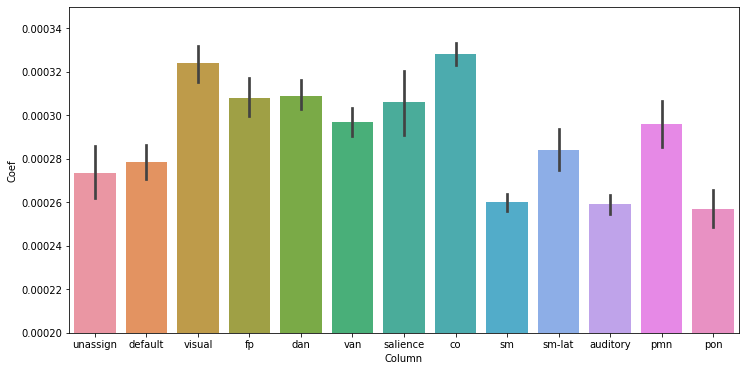

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

ax=sns.barplot(x='Column', y='Coef', data=df)
ax.set(ylim=(.0002, .00035))
ax.axhline(.00042, ls='--', color='r')

In [90]:
coef_cap=df['Coef']>.0002

In [68]:
cap=df[coef_cap]

In [108]:
cap['Row.Column']=cap['Row']+'.'+cap['Column']

In [123]:
cap.head()

,Row,Column,Coef,Row.Column
0,unassign,unassign,0.000608,unassign.unassign
1,unassign,unassign,0.000272,unassign.unassign
2,unassign,unassign,0.000423,unassign.unassign
3,unassign,unassign,0.000203,unassign.unassign
4,unassign,unassign,0.001053,unassign.unassign


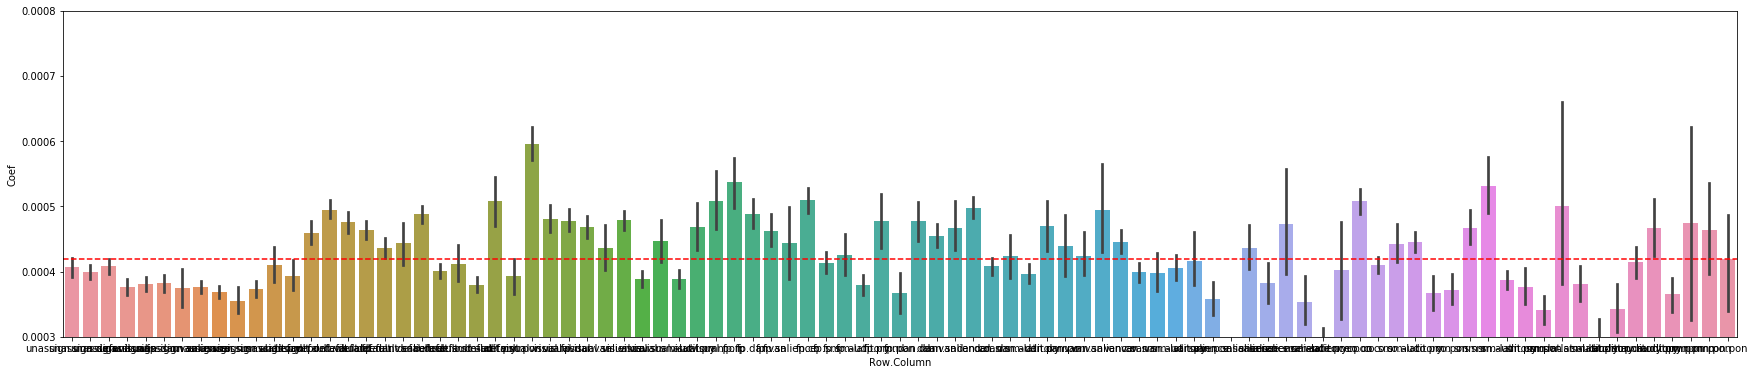

In [122]:
plt.figure(figsize=(30,6))
ax=sns.barplot(x='Row.Column', y='Coef', data=cap)
ax.set(ylim=(.0003, .0008))
ax.axhline(.00042, ls='--', color='r')

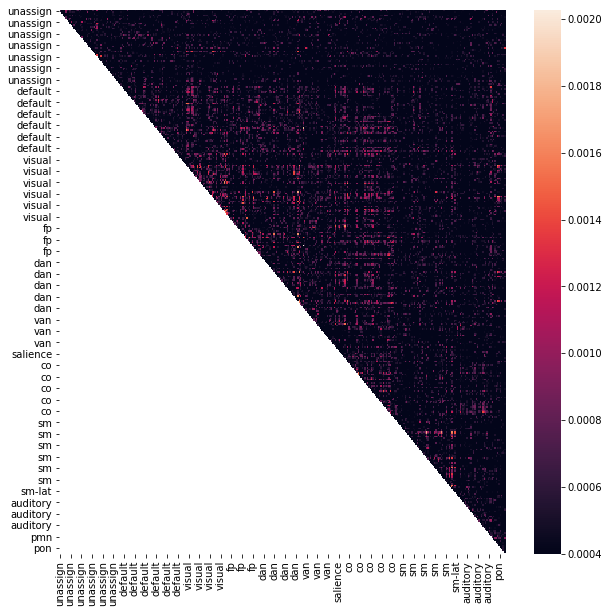

In [105]:
# Generate a mask for the upper triangle
mask = np.tril(np.ones_like(df, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df, mask=mask, vmin=.0004)

In [138]:
df.max()

Row          visual
Column       visual
Coef      0.0020268
dtype: object

In [152]:
k=df.nlargest(5,'Coef')

In [154]:
k.reset_index(drop=True, inplace=True)

In [155]:
k

,Row,Column,Coef
0,fp,dan,0.002027
1,default,dan,0.001824
2,sm,sm,0.001790
3,visual,dan,0.001737
4,sm,sm,0.001692


In [9]:
import plotFW
import os
import sys
import numpy as np
import reshape
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
Parcel_params=plotFW.loadParcelParams('Gordon333',thisDir+'data/Parcel_info/')

MSC01=reshape.matFiles(dataDir+'mem/MSC01_parcel_corrmat.mat')

In [11]:
f=np.random.choice(MSC01[0], 100, replace=False)

In [18]:
idx=np.random.randint(55278, size=(100))

In [30]:
test=MSC01[0][idx]

In [28]:
test.shape

(100,)

In [23]:
MSC01.shape[0]

10

In [25]:
idx.shape[0]

100